In [3]:
# Import libraries
from collections import Counter, OrderedDict
from itertools import chain
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 15
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 1000
import random
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Import csv file
metadata_path = "../data/item_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

In [7]:
# Create item list
item_list = metadata_df["item_id"].tolist()

# Create indexes for each item
item_index = {item: idx for idx, item in enumerate(item_list)}
index_item = {idx: item for item, idx in item_index.items()}

In [8]:
# Create property list

# Split on pipes
metadata_df["properties"] = metadata_df["properties"].str.split("|")

# Convert all properties to lowercase
metadata_df["properties"] = metadata_df["properties"].apply(lambda x: [w.lower() for w in x])

properties_list = metadata_df["properties"].tolist()

# Find set of unique properties and convert to a list
unique_properties = list(chain(*[list(set(tags)) for tags in properties_list]))
unique_properties = set(unique_properties)

# Create indexes for each property
property_index = {tag: idi for idi, tag in enumerate(unique_properties)}
index_properties = {idi: tag for tag, idi in property_index.items()}

In [9]:
# Import embeddings model and weights
embeddings_model = models.load_model("../models/embeddings_first_attempt.h5")
embeddings_model.load_weights("../models/embeddings_first_attempt_weights.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
# Extract embeddings
hotel_layer = embeddings_model.get_layer("item_embedding")
hotel_weights = hotel_layer.get_weights()[0]

# Normalize the embeddings so that we can calculate cosine similarity
hotel_weights = hotel_weights / np.linalg.norm(hotel_weights, axis = 1).reshape((-1, 1))

In [11]:
# Finding similar hotels
def find_similar_hotels(name, weights, index_name = "item", n = 5, return_dist = False, plot = False):
    
    # Select index and reverse index
    if index_name == "item":
        index = item_index
        rindex = index_item
    if index_name == "property":
        index = property_index
        rindex = index_properties
    
    # Check name is in index
    try:
        # Calculate dot product between item/property and all others
        distances = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f"{name} Not Found.")
        return
    
    # Sort distances from smallest to largest
    sorted_distances = np.argsort(distances)
    
    # Plot results if True
    if plot:
        # Find closest and most far away item
        far_away = sorted_distances[:n // 2]
        closest = sorted_distances[-n-1: len(distances) - 1]
        to_plot = [rindex[c] for c in far_away]
        to_plot.extend(rindex[c] for c in closest)
        
        # Find distances 
        dist = [distances[c] for c in far_away]
        dist.extend(distances[c] for c in closest)
        
        # Colors
        colors = ["hotpink" for _ in range(n // 2)]
        colors.extend("darkturquoise" for _ in range(n))
        
        # Data in DataFrame
        data = pd.DataFrame({"distance": dist}, index = to_plot)
        
        # Bar chart
        data["distance"].plot.barh(color = colors, figsize = (10, 8), edgecolor = "k", linewidth = 2)
        plt.xlabel("Cosine Similarity");
        plt.axvline(x = 0, color = "k");
        
        # Title
        name_str = f"Hotels Most and Least Similar to {name}"
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
    
    # Find the most similar
    closest = sorted_distances[-n:]

    # If return_dist True
    if return_dist:
        return distances, closest
    
    # Print the most similar and distances
    for c in reversed(closest):
        print(f"{index_name}: {rindex[c]} Similarity: {distances[c]:.{2}}")


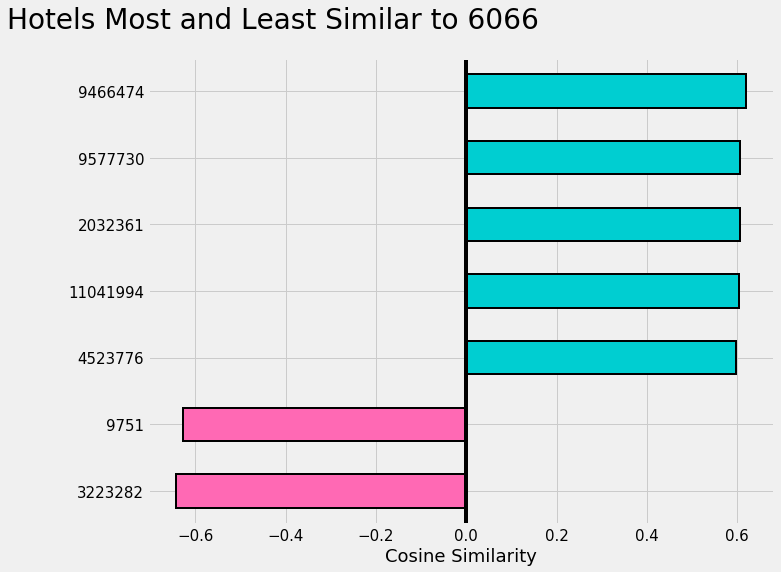

In [12]:
find_similar_hotels(6066, hotel_weights, plot = True)

In [13]:
# Extract property embeddings
properties_layer = embeddings_model.get_layer("property_embedding")
properties_weights = properties_layer.get_weights()[0]

# Normalize the embeddings so that we can calculate cosine similarity
properties_weights = properties_weights / np.linalg.norm(properties_weights, axis = 1).reshape((-1, 1))

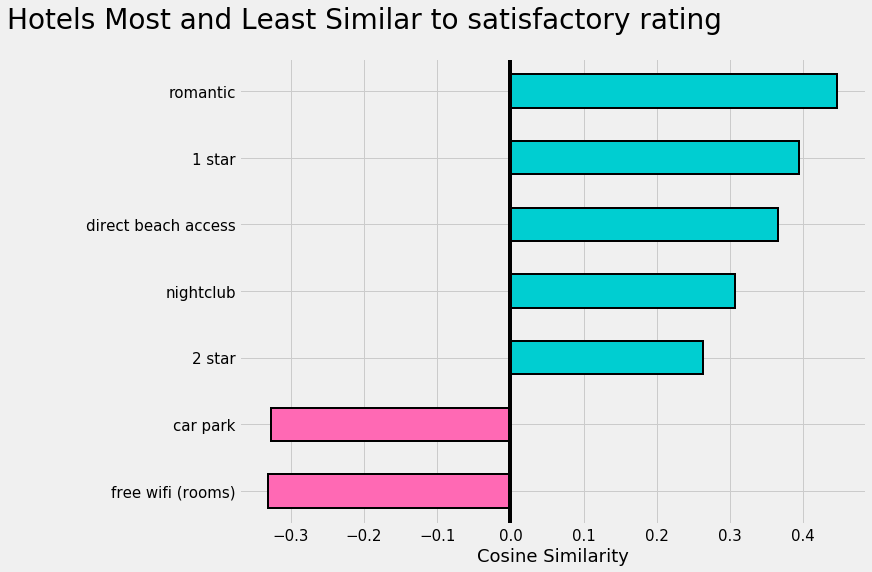

In [14]:
find_similar_hotels("satisfactory rating", properties_weights, index_name = "property", plot = True)

In [ ]:
# Reduce hotels
hotels_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 2).fit_transform(hotel_weights)
hotels_reduced.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 927142 samples in 0.040s...
[t-SNE] Computed neighbors for 927142 samples in 17376.099s...
[t-SNE] Computed conditional probabilities for sample 1000 / 927142
[t-SNE] Computed conditional probabilities for sample 2000 / 927142
[t-SNE] Computed conditional probabilities for sample 3000 / 927142
[t-SNE] Computed conditional probabilities for sample 4000 / 927142
[t-SNE] Computed conditional probabilities for sample 5000 / 927142
[t-SNE] Computed conditional probabilities for sample 6000 / 927142
[t-SNE] Computed conditional probabilities for sample 7000 / 927142
[t-SNE] Computed conditional probabilities for sample 8000 / 927142
[t-SNE] Computed conditional probabilities for sample 9000 / 927142
[t-SNE] Computed conditional probabilities for sample 10000 / 927142
[t-SNE] Computed conditional probabilities for sample 11000 / 927142
[t-SNE] Computed conditional probabilities for sample 12000 / 927142
[t-SNE] Computed conditional pro

[t-SNE] Computed conditional probabilities for sample 126000 / 927142
[t-SNE] Computed conditional probabilities for sample 127000 / 927142
[t-SNE] Computed conditional probabilities for sample 128000 / 927142
[t-SNE] Computed conditional probabilities for sample 129000 / 927142
[t-SNE] Computed conditional probabilities for sample 130000 / 927142
[t-SNE] Computed conditional probabilities for sample 131000 / 927142
[t-SNE] Computed conditional probabilities for sample 132000 / 927142
[t-SNE] Computed conditional probabilities for sample 133000 / 927142
[t-SNE] Computed conditional probabilities for sample 134000 / 927142
[t-SNE] Computed conditional probabilities for sample 135000 / 927142
[t-SNE] Computed conditional probabilities for sample 136000 / 927142
[t-SNE] Computed conditional probabilities for sample 137000 / 927142
[t-SNE] Computed conditional probabilities for sample 138000 / 927142
[t-SNE] Computed conditional probabilities for sample 139000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 250000 / 927142
[t-SNE] Computed conditional probabilities for sample 251000 / 927142
[t-SNE] Computed conditional probabilities for sample 252000 / 927142
[t-SNE] Computed conditional probabilities for sample 253000 / 927142
[t-SNE] Computed conditional probabilities for sample 254000 / 927142
[t-SNE] Computed conditional probabilities for sample 255000 / 927142
[t-SNE] Computed conditional probabilities for sample 256000 / 927142
[t-SNE] Computed conditional probabilities for sample 257000 / 927142
[t-SNE] Computed conditional probabilities for sample 258000 / 927142
[t-SNE] Computed conditional probabilities for sample 259000 / 927142
[t-SNE] Computed conditional probabilities for sample 260000 / 927142
[t-SNE] Computed conditional probabilities for sample 261000 / 927142
[t-SNE] Computed conditional probabilities for sample 262000 / 927142
[t-SNE] Computed conditional probabilities for sample 263000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 372000 / 927142
[t-SNE] Computed conditional probabilities for sample 373000 / 927142
[t-SNE] Computed conditional probabilities for sample 374000 / 927142
[t-SNE] Computed conditional probabilities for sample 375000 / 927142
[t-SNE] Computed conditional probabilities for sample 376000 / 927142
[t-SNE] Computed conditional probabilities for sample 377000 / 927142
[t-SNE] Computed conditional probabilities for sample 378000 / 927142
[t-SNE] Computed conditional probabilities for sample 379000 / 927142
[t-SNE] Computed conditional probabilities for sample 380000 / 927142
[t-SNE] Computed conditional probabilities for sample 381000 / 927142
[t-SNE] Computed conditional probabilities for sample 382000 / 927142
[t-SNE] Computed conditional probabilities for sample 383000 / 927142
[t-SNE] Computed conditional probabilities for sample 384000 / 927142
[t-SNE] Computed conditional probabilities for sample 385000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 495000 / 927142
[t-SNE] Computed conditional probabilities for sample 496000 / 927142
[t-SNE] Computed conditional probabilities for sample 497000 / 927142
[t-SNE] Computed conditional probabilities for sample 498000 / 927142
[t-SNE] Computed conditional probabilities for sample 499000 / 927142
[t-SNE] Computed conditional probabilities for sample 500000 / 927142
[t-SNE] Computed conditional probabilities for sample 501000 / 927142
[t-SNE] Computed conditional probabilities for sample 502000 / 927142
[t-SNE] Computed conditional probabilities for sample 503000 / 927142
[t-SNE] Computed conditional probabilities for sample 504000 / 927142
[t-SNE] Computed conditional probabilities for sample 505000 / 927142
[t-SNE] Computed conditional probabilities for sample 506000 / 927142
[t-SNE] Computed conditional probabilities for sample 507000 / 927142
[t-SNE] Computed conditional probabilities for sample 508000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 616000 / 927142
[t-SNE] Computed conditional probabilities for sample 617000 / 927142
[t-SNE] Computed conditional probabilities for sample 618000 / 927142
[t-SNE] Computed conditional probabilities for sample 619000 / 927142
[t-SNE] Computed conditional probabilities for sample 620000 / 927142
[t-SNE] Computed conditional probabilities for sample 621000 / 927142
[t-SNE] Computed conditional probabilities for sample 622000 / 927142
[t-SNE] Computed conditional probabilities for sample 623000 / 927142
[t-SNE] Computed conditional probabilities for sample 624000 / 927142
[t-SNE] Computed conditional probabilities for sample 625000 / 927142
[t-SNE] Computed conditional probabilities for sample 626000 / 927142
[t-SNE] Computed conditional probabilities for sample 627000 / 927142
[t-SNE] Computed conditional probabilities for sample 628000 / 927142
[t-SNE] Computed conditional probabilities for sample 629000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 741000 / 927142
[t-SNE] Computed conditional probabilities for sample 742000 / 927142
[t-SNE] Computed conditional probabilities for sample 743000 / 927142
[t-SNE] Computed conditional probabilities for sample 744000 / 927142
[t-SNE] Computed conditional probabilities for sample 745000 / 927142
[t-SNE] Computed conditional probabilities for sample 746000 / 927142
[t-SNE] Computed conditional probabilities for sample 747000 / 927142
[t-SNE] Computed conditional probabilities for sample 748000 / 927142
[t-SNE] Computed conditional probabilities for sample 749000 / 927142
[t-SNE] Computed conditional probabilities for sample 750000 / 927142
[t-SNE] Computed conditional probabilities for sample 751000 / 927142
[t-SNE] Computed conditional probabilities for sample 752000 / 927142
[t-SNE] Computed conditional probabilities for sample 753000 / 927142
[t-SNE] Computed conditional probabilities for sample 754000 / 927142
[t-SNE] Computed con

[t-SNE] Computed conditional probabilities for sample 863000 / 927142
[t-SNE] Computed conditional probabilities for sample 864000 / 927142
[t-SNE] Computed conditional probabilities for sample 865000 / 927142
[t-SNE] Computed conditional probabilities for sample 866000 / 927142
[t-SNE] Computed conditional probabilities for sample 867000 / 927142
[t-SNE] Computed conditional probabilities for sample 868000 / 927142
[t-SNE] Computed conditional probabilities for sample 869000 / 927142
[t-SNE] Computed conditional probabilities for sample 870000 / 927142
[t-SNE] Computed conditional probabilities for sample 871000 / 927142
[t-SNE] Computed conditional probabilities for sample 872000 / 927142
[t-SNE] Computed conditional probabilities for sample 873000 / 927142
[t-SNE] Computed conditional probabilities for sample 874000 / 927142
[t-SNE] Computed conditional probabilities for sample 875000 / 927142
[t-SNE] Computed conditional probabilities for sample 876000 / 927142
[t-SNE] Computed con

In [ ]:
# Reduce properties
properties_reduced = TSNE(n_components = 2, metric = "cosine", verbose = 2).fit_transform(properties_weights)
properties_reduced.shape